✅ Loaded trained model and preprocessors.
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 110s 3ms/step

🎯 Predicted Accuracy: 99.95%

❌ Misclassified Samples:
   Actual Label        Predicted Label
5        Benign       Brute Force -Web
6        Benign       Brute Force -Web
7        Benign       Brute Force -Web
10       Benign       Brute Force -Web
11       Benign       Brute Force -Web
12       Benign       Brute Force -Web
13       Benign       Brute Force -Web
14       Benign       Brute Force -Web
15       Benign       Brute Force -Web
16       Benign       Brute Force -Web
17       Benign       Brute Force -Web
18       Benign       Brute Force -Web
19       Benign       Brute Force -Web
20       Benign       Brute Force -Web
24       Benign       Brute Force -Web
25       Benign       Brute Force -Web
26       Benign       Brute Force -Web
27       Benign       Brute Force -Web
28       Benign       Brute Force -Web
29       Benign       Brute Force -Web
30       Benign       Brute Force -W

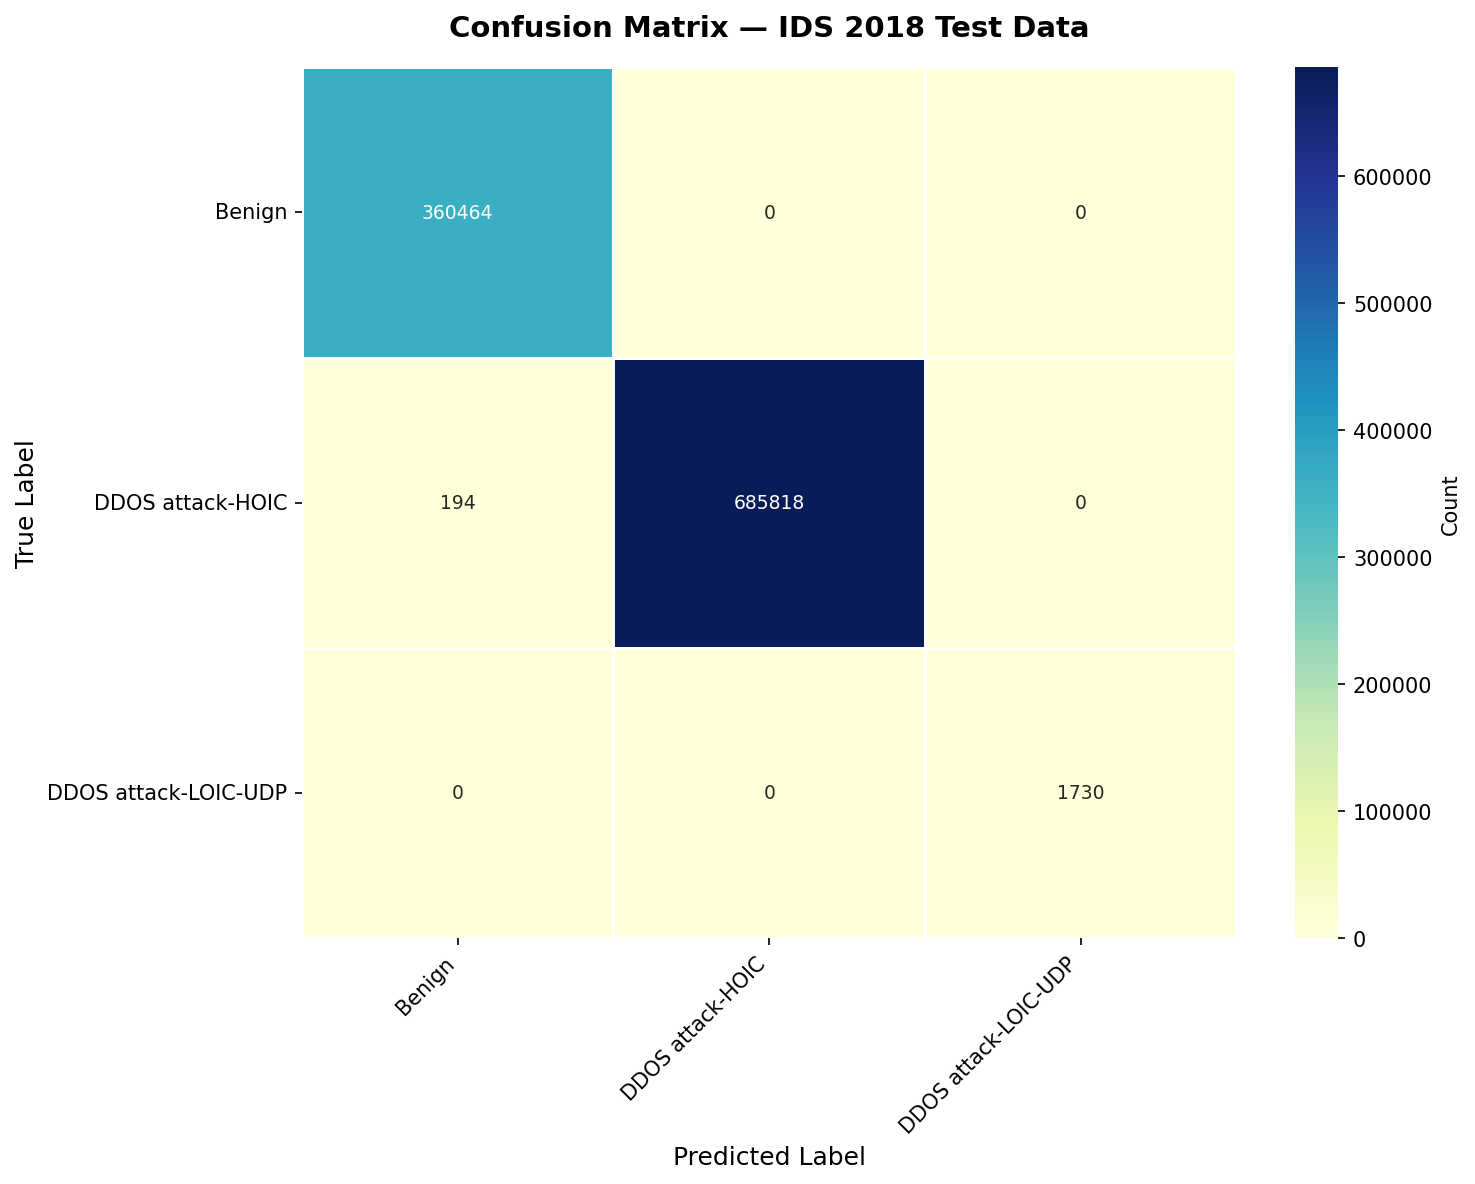

In [9]:
# =============================================
# ✅ IMPORTS
# =============================================
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# =============================================
# 1️⃣ LOAD TRAINED OBJECTS
# =============================================
model = load_model("ids_deep_model.keras")
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")
selector = joblib.load("selector.pkl")
var_thresh = joblib.load("var_thresh.pkl")
trained_columns = joblib.load("trained_columns.pkl")

print("✅ Loaded trained model and preprocessors.")

# =============================================
# 2️⃣ LOAD TEST DATA
# =============================================
test_path = r"C:\Users\shrin\Downloads\IDS 2018\02-21-2018.csv"
df = pd.read_csv(test_path)

# Remove accidental repeated headers
df = df[df.apply(lambda row: not row.astype(str).str.contains("Flow Duration", case=False).any(), axis=1)]

# Drop unnecessary columns
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Src Port', 'Dst Port', 'Protocol']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

# =============================================
# 3️⃣ CLEAN AND ALIGN DATA
# =============================================
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

if 'Label' not in df.columns:
    df['Label'] = 'Unknown'

X = df.drop(columns=['Label'])
y_true = df['Label']

missing_cols = [c for c in trained_columns if c not in X.columns]
extra_cols = [c for c in X.columns if c not in trained_columns]

for c in missing_cols:
    X[c] = 0
if extra_cols:
    X.drop(columns=extra_cols, inplace=True)

X = X[trained_columns]

# =============================================
# 4️⃣ APPLY SAME PREPROCESSING AS TRAINING
# =============================================
X = var_thresh.transform(X)
X = selector.transform(X)
X_scaled = scaler.transform(X)

# =============================================
# 5️⃣ PREDICT
# =============================================
y_pred = np.argmax(model.predict(X_scaled), axis=1)
y_pred_labels = le.inverse_transform(y_pred)

df_results = pd.DataFrame({
    "Actual Label": y_true.values,
    "Predicted Label": y_pred_labels
})

# =============================================
# 6️⃣ CALCULATE ACCURACY
# =============================================
if not all(y_true == "Unknown"):
    # Only use classes that exist in both training and testing
    valid_classes = [c for c in np.unique(y_true) if c in le.classes_]
    y_true_encoded = le.transform(y_true)
    acc = accuracy_score(y_true_encoded, y_pred) * 100
    print(f"\n🎯 Predicted Accuracy: {acc:.2f}%")
else:
    print("\n⚠️ Accuracy can't be computed (no actual labels found).")

# =============================================
# 7️⃣ SHOW MISCLASSIFIED SAMPLES
# =============================================
misclassified = df_results[df_results["Actual Label"] != df_results["Predicted Label"]]

print("\n❌ Misclassified Samples:")
if misclassified.empty:
    print("✅ No misclassifications found! Excellent job 🎉")
else:
    print(misclassified.head(50))
    print(f"\nTotal Misclassifications: {len(misclassified)} / {len(df_results)}")
    print(f"Accuracy (Recheck): {(1 - len(misclassified) / len(df_results)) * 100:.2f}%")

# =============================================
# 8️⃣ EVALUATION METRICS & CONFUSION MATRIX
if not all(y_true == "Unknown"):
    # Safely compute metrics only for overlapping classes
    labels = [le.transform([cls])[0] for cls in valid_classes]

    print("\n📊 Classification Report (only for test classes):")
    print(classification_report(
        le.transform(y_true), y_pred, 
        labels=labels, 
        target_names=valid_classes
    ))

    # === Clean & Professional Confusion Matrix ===
    plt.figure(figsize=(10, 8), dpi=150)
    cm = confusion_matrix(le.transform(y_true), y_pred, labels=labels)

    sns.heatmap(
        cm,
        annot=True,          # show numbers
        fmt='d',             # integer values
        cmap='YlGnBu',       # calm color map (green-blue)
        linewidths=0.5,      # thin lines for clarity
        cbar_kws={'label': 'Count'},
        xticklabels=valid_classes,
        yticklabels=valid_classes,
        annot_kws={"size": 9}
    )

    plt.title("Confusion Matrix — IDS 2018 Test Data", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()


In [10]:
# =======================================================
# 🔍 Compare Actual vs Predicted — Find Misclassified & Correctly Classified
# =======================================================

# Misclassified samples
misclassified = df_results[df_results["Actual Label"] != df_results["Predicted Label"]]
correctly_classified = df_results[df_results["Actual Label"] == df_results["Predicted Label"]]

# === MISCLASSIFIED ===
print("\n❌ Misclassified Samples:")
if misclassified.empty:
    print("✅ No misclassifications found! Excellent job 🎉")
else:
    print(misclassified.head(50).to_string(index=False))
    print(f"\n🔴 Total Misclassifications: {len(misclassified)} / {len(df_results)}")
    print(f"🔹 Misclassification Rate: {(len(misclassified) / len(df_results)) * 100:.2f}%")
    print(f"✅ Accuracy (Recheck): {(1 - len(misclassified) / len(df_results)) * 100:.2f}%")

# === CORRECTLY CLASSIFIED ===
print("\n✅ Correctly Predicted Samples:")
if correctly_classified.empty:
    print("⚠️ No correctly predicted samples found. Model may need retraining.")
else:
    print(correctly_classified.head(50).to_string(index=False))
    print(f"\n🟢 Total Correct Predictions: {len(correctly_classified)} / {len(df_results)}")
    print(f"🔹 Correct Prediction Rate: {(len(correctly_classified) / len(df_results)) * 100:.2f}%")



❌ Misclassified Samples:
Actual Label       Predicted Label
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign      Brute Force -Web
      Benign DoS attacks-GoldenEye
      Benign DoS attacks-GoldenEye
      Benign DoS attacks-GoldenEye
      Benign      Brute Force -Web
      Benign      Brute Force

In [11]:
# =======================================================
# ✅ MISCLASSIFIED & CORRECTLY CLASSIFIED SUMMARY
# =======================================================

# Separate misclassified and correctly classified samples
misclassified = df_results[df_results["Actual Label"] != df_results["Predicted Label"]]
correctly_classified = df_results[df_results["Actual Label"] == df_results["Predicted Label"]]

# === MISCLASSIFIED ===
print("\n❌ Misclassified Samples:")
if misclassified.empty:
    print("✅ No misclassifications found! Excellent job 🎉")
else:
    print(misclassified.head(10).to_string(index=False))
    print(f"\n🔴 Total Misclassifications: {len(misclassified)} / {len(df_results)}")
    print(f"🔹 Misclassification Rate: {(len(misclassified) / len(df_results)) * 100:.2f}%")
    print(f"✅ Accuracy (Recheck): {(1 - len(misclassified) / len(df_results)) * 100:.2f}%")

# === CORRECTLY CLASSIFIED ===
print("\n✅ Correctly Predicted Samples:")
if correctly_classified.empty:
    print("⚠️ No correctly predicted samples found. Model may need retraining.")
else:
    print(correctly_classified.head(10).to_string(index=False))
    print(f"\n🟢 Total Correct Predictions: {len(correctly_classified)} / {len(df_results)}")
    print(f"🔹 Correct Prediction Rate: {(len(correctly_classified) / len(df_results)) * 100:.2f}%")



❌ Misclassified Samples:
Actual Label  Predicted Label
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web
      Benign Brute Force -Web

🔴 Total Misclassifications: 563 / 1048575
🔹 Misclassification Rate: 0.05%
✅ Accuracy (Recheck): 99.95%

✅ Correctly Predicted Samples:
Actual Label Predicted Label
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign
      Benign          Benign

🟢 Total Correct Predictions: 1048012 / 1048575
🔹 Correct Prediction Rate: 99.95%
